<a href="https://colab.research.google.com/github/queens-supercluster/SpeechDiarization/blob/main/Wysdom_Speech_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
!pip install hmmlearn

import whisper
import datetime

import subprocess

import torch
import pyannote.audio

from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 9.8 MB/s eta 0:00:00


In [2]:
num_speakers = 2 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'medium' #@param ['tiny', 'base', 'small', 'medium', 'large']


model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'


In [3]:
# upload audio file
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))

Saving IR_200171107730220209-AG.wav to IR_200171107730220209-AG.wav


In [4]:
#even if file is formatted in .wav, call subprocess function to ensure correct format of .wav format that is accepted by Whisper
subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
path = 'audio.wav'

In [5]:
model = whisper.load_model(model_size)

100%|█████████████████████████████████████| 1.42G/1.42G [00:21<00:00, 70.2MiB/s]


In [6]:
result = model.transcribe(path)
segments = result["segments"]

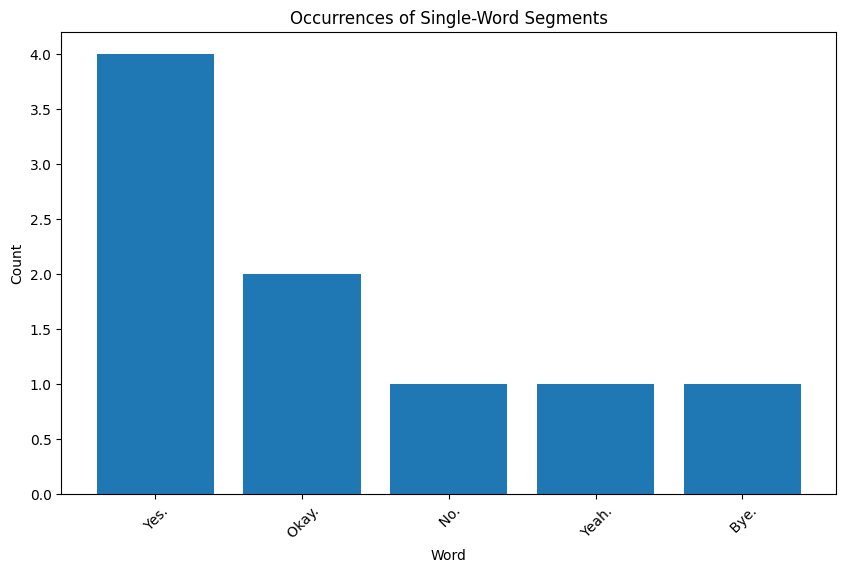

In [7]:
#Removing single token filler words from segments

single_word_segments = [segment for segment in segments if len(segment["text"].split()) == 1]


word_counts = {}
for segment in single_word_segments:
    word = segment["text"]
    word_counts[word] = word_counts.get(word, 0) + 1

sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

words = [word for word, count in sorted_word_counts]
counts = [count for word, count in sorted_word_counts]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Occurrences of Single-Word Segments")
plt.xticks(rotation=45)
plt.show()

words_to_remove = words  # List of words to remove

segments = [segment for segment in segments if segment['text'] not in words_to_remove]

In [8]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)

audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  return embedding_model(waveform[None])

In [9]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)

In [10]:
# Removing chatbot segment from embeddings based on start and end words

start_index = None
end_index = None

start_word = 'Welcome' #@param {type:"string"}

end_word = 'Thank' #@param {type:"string"}

for i, segment in enumerate(segments):
    if segment["text"].startswith((" ")+start_word):
        start_index = i
    elif segment["text"].startswith((" ")+end_word):
        end_index = i
        break

# Removing the segments from the speech embeddings and segments list
if start_index is not None and end_index is not None:
    embeddings = np.concatenate([embeddings[:start_index], embeddings[end_index+1:]], axis=0)
    segments = segments[:start_index] + segments[end_index+1:]
else:
    print("Start or end index not found. No removal performed.")

In [11]:
# Clustering for speaker identification

clustering = KMeans(num_speakers, n_init =100).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

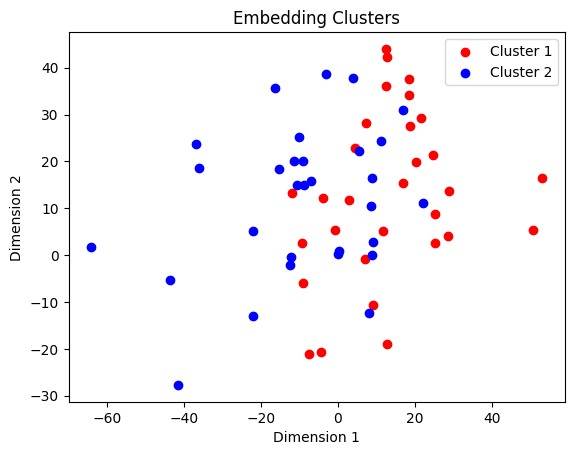

In [12]:
colors = ['r','b','g','m']
for i in range(num_speakers):
    cluster_points = embeddings[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {i+1}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Embedding Clusters')
plt.legend()
plt.show()

In [13]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w")

for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:].encode('ascii', 'ignore').decode('ascii') + ' ')
from sklearn.mixture import GaussianMixture
f.close()